In [1]:
# import the usual libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split

## Q1 Cleaning Data (20 marks)

You will use the UCI Credit Approval Dataset where each record is a credit card application. All attribute names and values have been changed to meaningless symbols to maintain confidentiality. The dataset has been cleaned to remove missing attributes. The data is stored in a comma-separated file (csv) here. Each line describes an instance using 16 columns: the first 15 columns represent the attributes of the application, and the last column is the ground truth label for credit card approval. Note: The last column should not be treated as an attribute.

Required:

1. Clean the dataset and do any type conversions necessary
2. Ensure there are no null values, (imputing any if encountered)
3. Encode all categorical attributes see examples here
4. Scale the attributes of the dataset
5. Perform PCA to obtain attributes with which explains 95% of the variance in the data.

In [2]:
# lets open the dataset. There appears to be no columns in the csv so lets artificially create our own based on website
# info
df = pd.read_csv("data/data.csv",names=["A"+str(x) for x in range(1,17,1)])
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [3]:
#lets check the data types
df.dtypes

A1      object
A2      object
A3     float64
A4      object
A5      object
A6      object
A7      object
A8     float64
A9      object
A10     object
A11      int64
A12     object
A13     object
A14     object
A15      int64
A16     object
dtype: object

In [4]:
# from inspection it looks like null values are encoded as '?'. This presents a problem since we dont want it to be a
# category or to get converted to a float or int. For now lets replace it with np.nan so it will be ignored or force error.
df.replace(to_replace='?',value=np.nan,inplace=True)
df.isnull().any()

A1      True
A2      True
A3     False
A4      True
A5      True
A6      True
A7      True
A8     False
A9     False
A10    False
A11    False
A12    False
A13    False
A14     True
A15    False
A16    False
dtype: bool

In [16]:
# lets make a copy
df2 = df.copy()
# --------------------------------------------------------------------------------------------------------------------------#
# lets use categorical codes to encode columns A1,A4,A5,A6,A7,A9,A10,A12,A13,A16 based on attribute info.
# A1: b, a.  A2: continuous.
# A3: continuous. A4: u, y, l, t.  A5: g, p, gg. A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
# A7: v, h, bb, j, n, z, dd, ff, o.   A8: continuous. A9: t, f.    A10: t, f.  A11: continuous.  A12: t, f.  A13: g, p, s.
# A14: continuous.     A15: continuous.     A16: +,- (class attribute)
# -------------------------------------------------------------------------------------------------------------------------#
# lets encode A1
df2['A1'] = df2['A1'].apply(lambda x : {'a':0,'b':1}[x] if x in ['a','b'] else x)
# lets make A2 a float
df2['A2'] = df2['A2'].apply(lambda x : float(x))
# Lets encode A4
df2['A4'] = df2['A4'].apply(lambda x : {'u':0,'y':1,'l':2,'t':3}[x] if x in ['u','y','l','t'] else x)
# Lets encode A5
df2['A5'] = df2['A5'].apply(lambda x : {'g':0,'p':1,'gg':2}[x] if x in ['g','p','gg'] else x)
# lets encode A6
a6codes = 'c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff'.split(', ')
a6dict = dict(zip(a6codes,range(len(a6codes))))
df2['A6'] = df2['A6'].apply(lambda x : a6dict[x] if x in a6dict else x)
# lets encode A7
a7codes = 'v, h, bb, j, n, z, dd, ff, o'.split(', ')
a7dict = dict(zip(a7codes,range(len(a7codes))))
df2['A7'] = df2['A7'].apply(lambda x : a7dict[x] if x in a7dict else x)
# now columns A9,10,12,13 have no nulls so we can use categorical codes directly
for col in ['A9','A10','A12','A13']:
    df2[col] = df2[col].astype('category').cat.codes
#lets make A14 integer
df2['A14'] = df2['A14'].apply(lambda x : float(x) if x!=np.nan else x)
# lets encode A16
df2['A16'] = df2['A16'].apply(lambda x : {'-':0,'+':1}[x] if x in ['-','+'] else x)
print("Lets confirm datatypes are all numerical\n",df2.dtypes,"\n")
print("Lets check which columns have null values\n",df2.isnull().any())

Lets confirm datatypes are all numerical
 A1     float64
A2     float64
A3     float64
A4     float64
A5     float64
A6     float64
A7     float64
A8     float64
A9        int8
A10       int8
A11      int64
A12       int8
A13       int8
A14    float64
A15      int64
A16      int64
dtype: object 

Lets check which columns have null values
 A1      True
A2      True
A3     False
A4      True
A5      True
A6      True
A7      True
A8     False
A9     False
A10    False
A11    False
A12    False
A13    False
A14     True
A15    False
A16    False
dtype: bool


In [17]:
# ok so now that all columns are numerical lets impute the missing values using mean and axis = 0 for columns.
fill_nan = Imputer(missing_values=np.nan,strategy='mean',axis=0)
df2 = pd.DataFrame(fill_nan.fit_transform(df2),columns=["A"+str(x) for x in range(1,17,1)])
print("Check if any nan in dataframe\n" , df2.isnull().any())
df2.head()

Check if any nan in dataframe
 A1     False
A2     False
A3     False
A4     False
A5     False
A6     False
A7     False
A8     False
A9     False
A10    False
A11    False
A12    False
A13    False
A14    False
A15    False
A16    False
dtype: bool


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1.0,30.83,0.000,0.0,0.0,9.0,0.0,1.25,1.0,1.0,1.0,0.0,0.0,202.0,0.0,1.0
1,0.0,58.67,4.460,0.0,0.0,8.0,1.0,3.04,1.0,1.0,6.0,0.0,0.0,43.0,560.0,1.0
2,0.0,24.50,0.500,0.0,0.0,8.0,1.0,1.50,1.0,0.0,0.0,0.0,0.0,280.0,824.0,1.0
3,1.0,27.83,1.540,0.0,0.0,9.0,0.0,3.75,1.0,1.0,5.0,1.0,0.0,100.0,3.0,1.0
4,1.0,20.17,5.625,0.0,0.0,9.0,0.0,1.71,1.0,0.0,0.0,0.0,2.0,120.0,0.0,1.0


In [18]:
# lets have a quick look at the metrics
df2.describe()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,0.690265,31.568171,4.758725,0.244152,0.244152,5.910426,1.155653,2.223406,0.523188,0.427536,2.40000,0.457971,0.176812,184.014771,1017.385507,0.444928
std,0.458678,11.853273,4.978163,0.434751,0.434751,4.446021,2.064807,3.346513,0.499824,0.495080,4.86294,0.498592,0.557869,172.159274,5210.102598,0.497318
min,0.000000,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,22.670000,1.000000,0.000000,0.000000,2.000000,0.000000,0.165000,0.000000,0.000000,0.00000,0.000000,0.000000,80.000000,0.000000,0.000000
50%,1.000000,28.625000,2.750000,0.000000,0.000000,6.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,160.000000,5.000000,0.000000
75%,1.000000,37.707500,7.207500,0.000000,0.000000,9.000000,1.000000,2.625000,1.000000,1.000000,3.00000,1.000000,0.000000,272.000000,395.500000,1.000000
max,1.000000,80.250000,28.000000,2.000000,2.000000,13.000000,8.000000,28.500000,1.000000,1.000000,67.00000,1.000000,2.000000,2000.000000,100000.000000,1.000000


In [19]:
# ok good so 690 counts across the board. The metrics for A14 and A15 seem a bit high, but the scaler should take care of it.
# lets follow convention and make X the feature matrix and y the target
X = df2[df2.columns[:-1]]
y = df2['A16']
# lets now scale the feature matrix
X = StandardScaler().fit_transform(X)
# lets fit the data to find the Principle components
pca = PCA(0.95)
X2 = pca.fit_transform(X)
# now lets compare the shape of the PCA matrix and the original and check the explained variances.
print(X2.shape,X.shape)
pca.explained_variance_ratio_

(690, 13) (690, 15)


array([0.18663649, 0.12759685, 0.10678856, 0.08640741, 0.07540985,
       0.06528208, 0.05988155, 0.05826648, 0.05024077, 0.04831406,
       0.04418061, 0.03516738, 0.03098979])

so it looks like 13 principle components explain 95% or more of the data.

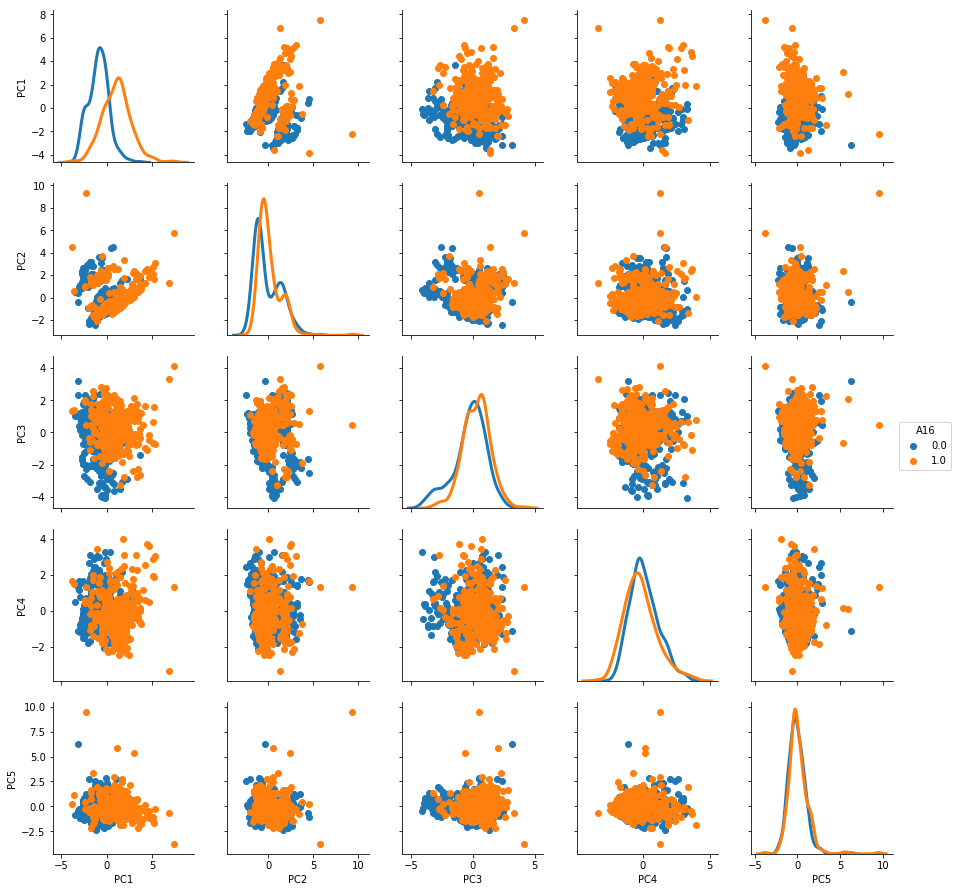

In [20]:
# lets have a look at a Pairplot to guage any potential relationships for a set of principle components
df3 = pd.DataFrame(data = X2, columns=["PC"+str(x +1) for x in range(X2.shape[1])])
df3 = pd.concat([df3,y],axis=1)
num_pc = 5 #number of principle components
g = sns.PairGrid(df3,x_vars=df3.columns[:num_pc],y_vars=df3.columns[:num_pc],hue='A16')
g = g.map_upper(plt.scatter)
g = g.map_lower(plt.scatter)
g = g.map_diag(sns.kdeplot, lw=3, legend=False)
g = g.add_legend()

## Q2 Random Forest Classifier (50 marks)
Required:

Part 1: Using the RandomForest Classifier provided by the sklearn library

1. Initialize the classifier with default arbitrary paramenters
2. Train the classifier
3. Determine the recall score of the classifier

Part 2: Using the RandomizedSearchCV module provided by the sklearn library

1. Do parameter tuning to obtain the optimal parameters to initialize the RandomForest Classifier. The parameters to tune are as follow:

    1. n_estimators
    2. max_features
    3. max_depth
    4. min_samples_split
    5. min_sample_leaf
    6. bootstrap
    
2. Determine the recall score of the classifier

In [22]:
# lets shuffle the dataframe and lets make a new feature matrix and a new target matrix for training and testing.
df3 = df2.copy().sample(frac=1)
X_train,X_test,y_train,y_test = train_test_split(df3[df3.columns[:-1]],df3['A16'],test_size=0.2,random_state=1)
# no need to scale data for Random Forest Classfier as its entropy based.
# Lets fit data and compute recall score
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
print("Recall score is : {}".format(recall_score(y_test,y_pred)))

Recall score is : 0.8852459016393442


In [23]:
# now lets scan some parameters to find the best combination
clf = RandomForestClassifier()
param_dist = {"n_estimators":[9,10,11],
              "max_depth": [3,None],
              "max_features": ['auto',None],
              "min_samples_split": [2,3,4],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True, False]}
rand_search = RandomizedSearchCV(clf,param_distributions=param_dist)
rand_search.fit(X_train,y_train)
rand_search.best_params_

{'bootstrap': True,
 'max_depth': 3,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 11}

In [25]:
# Lets fit data and compute recall score for new classifier parameters
random_forest_new = RandomForestClassifier(bootstrap=True,max_depth=3,max_features='auto',min_samples_leaf=2,\
                                       min_samples_split=4,n_estimators=11)
random_forest_new.fit(X_train, y_train)
y_pred_new = random_forest_new.predict(X_test)
print("Recall score is : {}".format(recall_score(y_test,y_pred_new)))

Recall score is : 0.9344262295081968


## Q3 KNN Classifier (30 marks)
Required

Part 1: Using the KNN Classifier provided by the sklearn library

1. Initialize the classifier with default value for n_neighbors
2. Train the classifier
3. Determine the recall score of the classifier

Part 2: Using the cross_val_score module provided by the sklearn library

1. Perform 10 fold cross validation to obtain the optimal value to use for n_neighbor
2. Retrain the classifier
3. Determine the recall score of the classifier

In [44]:
# lets make a new feature matrix and a new target matrix set for training and testing
df4 = df2.copy()
# lets scale the features
Xscal = StandardScaler().fit_transform(df4[df4.columns[:-1]])
X2_train,X2_test,y2_train,y2_test = train_test_split(Xscal,df4['A16'],test_size=0.2,random_state=1)
#initialise KNN with defaults
knn = KNeighborsClassifier()
# fitting the model
knn.fit(X2_train, y2_train)
# Score the model
y2_pred = knn.predict(X2_test)
print("Recall score is : {}".format(recall_score(y2_test,y2_pred)))

Recall score is : 0.8412698412698413


The best k value is : 5


Text(5,0.806167,'Best_K')

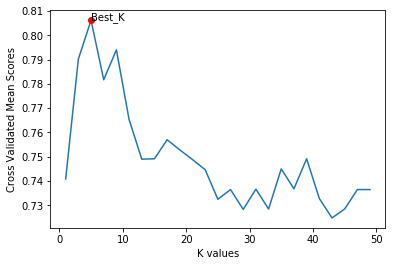

In [48]:
# creating odd list of K for KNN
neighbors = filter(lambda x: x % 2 != 0, list(range(1,50)))
# empty dict that will hold cv scores
cv_scores = {}
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X2_train, y2_train, cv=10, scoring='recall') # use recall score for apples to apples.
    cv_scores[k] = scores.mean()
#find the best k by looking for the highest score
best_k = max(cv_scores, key=lambda k: cv_scores[k])
print("The best k value is : {}".format(best_k))
#let look at a quick plot of k vs mean score
x_vals = []
y_vals = []
for item in cv_scores:
    x_vals.append(item)
    y_vals.append(cv_scores[item])
plt.plot(x_vals,y_vals)
plt.xlabel('K values')
plt.ylabel('Cross Validated Mean Scores')
plt.plot(best_k,y_vals[x_vals.index(best_k)], 'ro')
plt.annotate(xy=(best_k,y_vals[x_vals.index(best_k)]),s='Best_K')

In [49]:
# rerunning KNN with new k
#initialise KNN with defaults
knn_new = KNeighborsClassifier(n_neighbors=best_k)
# fitting the model
knn_new.fit(X2_train, y2_train)
# Score the model
y2_pred_new = knn_new.predict(X2_test)
print("Recall score is : {}".format(recall_score(y2_test,y2_pred_new)))

Recall score is : 0.8412698412698413


it appears in this case the best number of k's was  the same as the default.